In [1]:
import sys

sys.path.append('../')

import os
import h5py
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numba
import numpy as np
import torch
from numpy.fft import fft, fft2, fftshift, ifft, ifft2, ifftshift
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.nn import DataParallel
from tqdm import tqdm

from kwave.ktransducer import *
from kwave.utils import *
from models.ADMM import ADMM_Batched
from models.APACT import APACT
from models.WienerNet import Wiener_Batched
from utils.data import load_mat
from utils.simulations import PSF, get_water_SoS, wavefront_real
from utils.utils_torch import get_fourier_coord
from utils.visualization import normalize, standardize
from utils.reconstruction import deconvolve_sinogram, get_delays, delay_and_sum, gaussian_kernel

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'

### Load Initial Pressure

Text(0.5, 1.0, 'Initial Pressure')

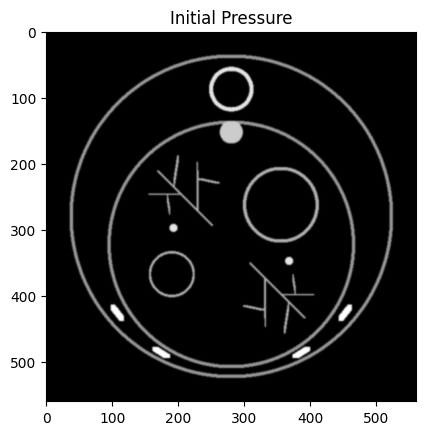

In [2]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))

plt.imshow(IP_img, cmap='gray')
plt.title('Initial Pressure')

### Load in Sinograms

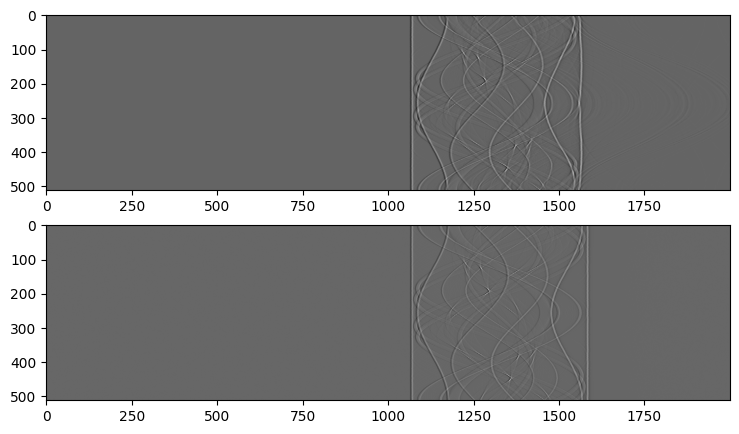

In [3]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram_uniform += np.random.normal(0, 1e-4, sinogram_uniform.shape)

plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Load and Deconvolve EIR

(1, 2000)


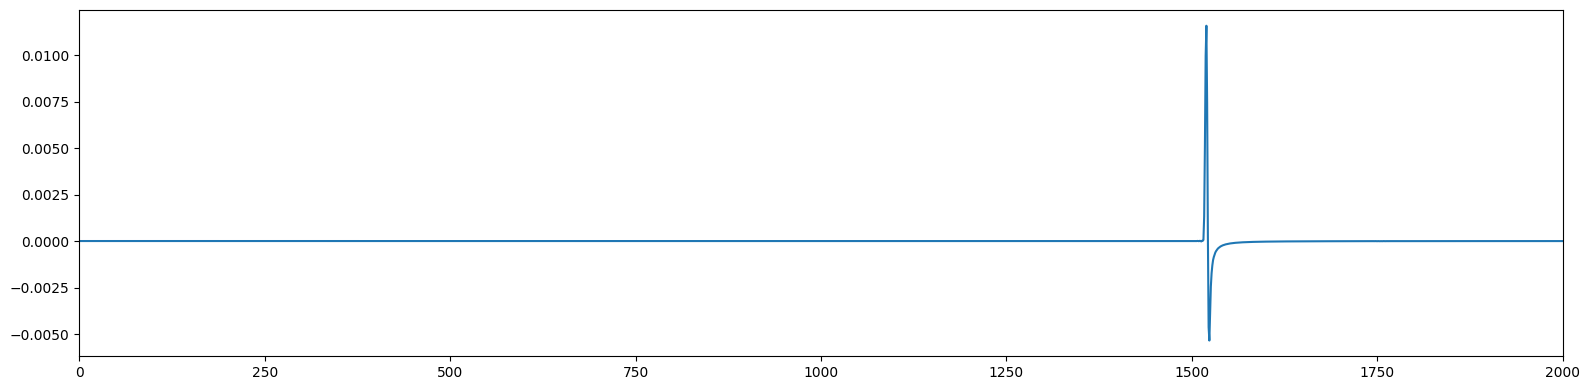

In [4]:
EIR = load_mat(os.path.join(data_path, 'EIR_KWAVE.mat'))
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

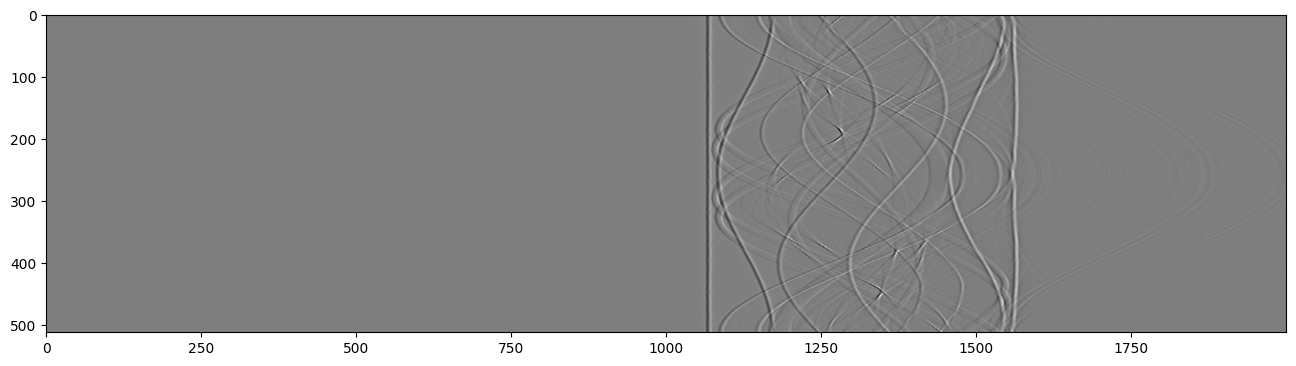

In [5]:
sinogram_deconv = deconvolve_sinogram(sinogram, EIR)

plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv, cmap='gray')
plt.show()

In [6]:
Nx, Ny = 800, 800
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [7]:
R = 9.9e-3 # Radius to center [m].
l = 3.2e-3 # Patch size [m].
T = 29.5 # Temperature of water [C].
v0 = get_water_SoS(T) # Background SoS [m/s].
v1 = 1564.4 # Avergae SoS in tissue [m/s].

print(v0, v1)

1508.0046878478038 1564.4


### Uniform SoS

In [8]:
gt = delay_and_sum(R_ring=0.05,
                   T_sample=1/(40e6),
                   v0=v0,
                   sinogram=sinogram_uniform[:,0:],
                   x_vec=kgrid.x_vec[:],
                   y_vec=kgrid.y_vec[:],
                   d_delay=0)
img_size = 560
x_c, y_c = 400, 400
gt = gt[x_c-img_size//2:+x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

Text(0.5, 1.0, 'Histogram')

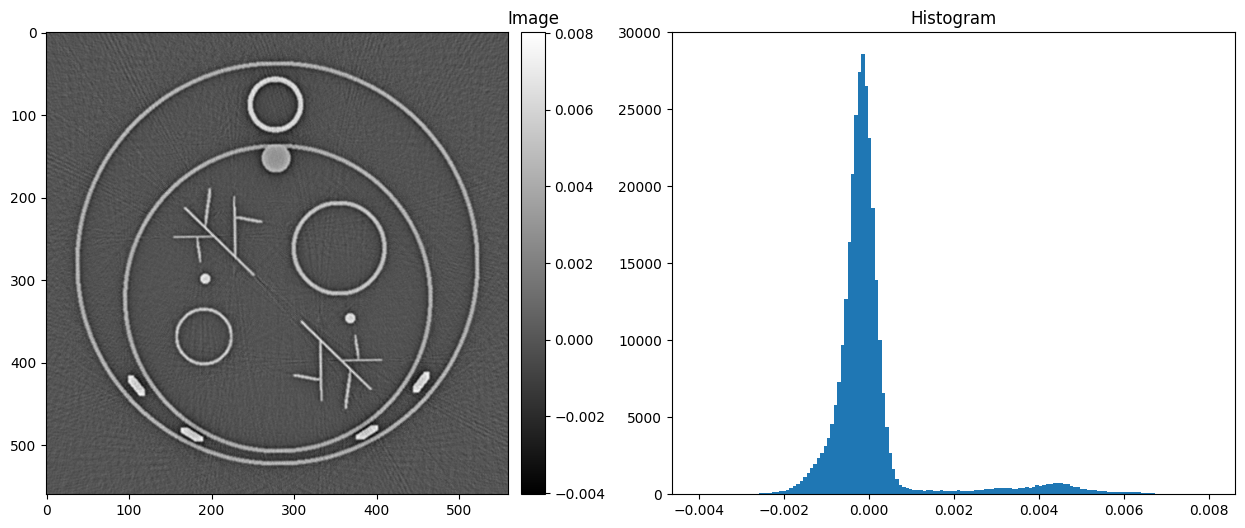

In [9]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(gt, cmap='gray')
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(gt.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### Conventional DAS

In [10]:
baseline = delay_and_sum(R_ring=0.05,
                         T_sample=1/(40e6),
                         v0=1517.6,
                         sinogram=sinogram[:,0:],
                         x_vec=kgrid.x_vec[:],
                         y_vec=kgrid.y_vec[:],
                         d_delay=0)
baseline = baseline[x_c-img_size//2:+x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

Text(0.5, 1.0, 'Histogram')

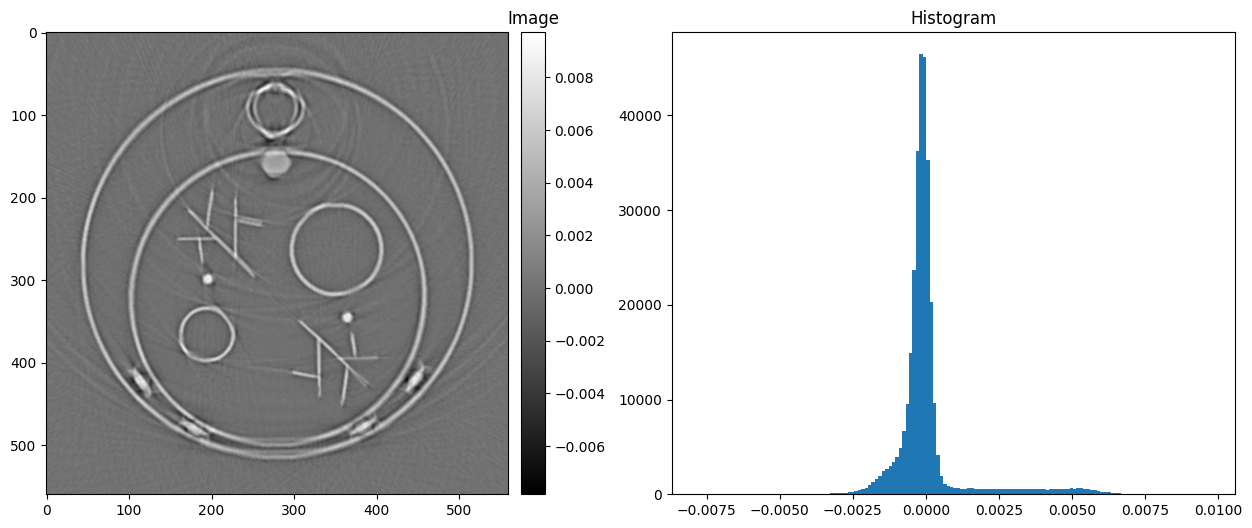

In [11]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(baseline, cmap='gray')
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(baseline.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### APACT

In [12]:
delays_apact = np.arange(-8e-4, 8e-4, 1e-4)
recons = []
for d_delay in delays_apact:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          v0=v0,
                          sinogram=sinogram[:,0:],
                          x_vec=kgrid.x_vec[:],
                          y_vec=kgrid.y_vec[:],
                          d_delay=d_delay)
    recons.append(recon)
recons = np.array(recons)
recons = recons[:,x_c-img_size//2:x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

In [13]:
l = 3.2e-3        
obss = []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        obs = torch.Tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
        obss.append(obs)

In [14]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)

In [15]:
model = APACT(delays=delays_apact, dc_range=(0e-4, 4e-4), amp=3.2e-4, step=4e-5)
model.to(device)
model.eval()

rec_full_apact = np.zeros_like(recons[0])
for i in tqdm(range(25)):
    for j in tqdm(range(25)):
        obs = obss[i*25+j] * gaussian_window
        obs = obs.unsqueeze(0).to(device)
        with torch.no_grad():
            rec, _, _, _ = model(obs)
        rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
        rec_full_apact[20*i:20*i+80, 20*j:20*j+80] += rec

100%|██████████| 25/25 [22:09<00:00, 53.19s/it]


Text(0.5, 1.0, 'Histogram')

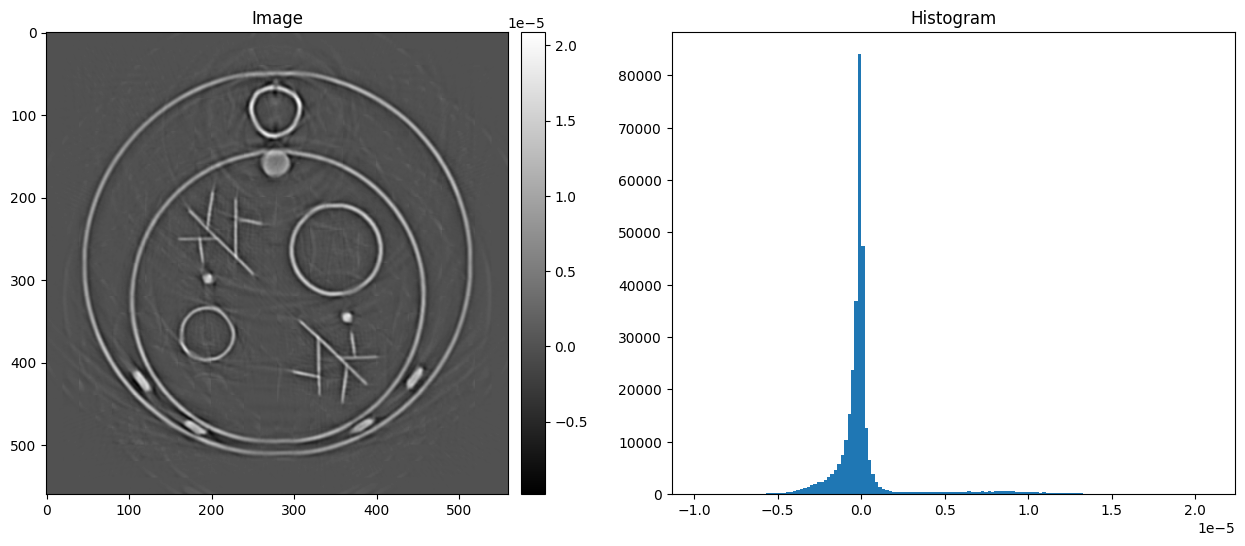

In [16]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(rec_full_apact, cmap='gray')
plt.title('Image', fontsize=12)
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)

ax2 = plt.subplot(1,2,2)
plt.hist(rec_full_apact.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

### Deconvolution with Single Body PSFs

In [17]:
n_delays = 32
delays = get_delays(R, v0, v1, n_delays, 'uniform')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          v0=v0,
                          sinogram=sinogram[:,0:],
                          x_vec=kgrid.x_vec[:],
                          y_vec=kgrid.y_vec[:],
                          d_delay=d_delay,
                          ring_error=1.5e-5)
    recons.append(recon)
recons = np.array(recons)
recons = recons[:,x_c-img_size//2:x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

[0.00000000e+00 1.38149699e-05 2.76299399e-05 4.14449098e-05
 5.52598798e-05 6.90748497e-05 8.28898197e-05 9.67047896e-05
 1.10519760e-04 1.24334729e-04 1.38149699e-04 1.51964669e-04
 1.65779639e-04 1.79594609e-04 1.93409579e-04 2.07224549e-04
 2.21039519e-04 2.34854489e-04 2.48669459e-04 2.62484429e-04
 2.76299399e-04 2.90114369e-04 3.03929339e-04 3.17744309e-04
 3.31559279e-04 3.45374249e-04 3.59189219e-04 3.73004188e-04
 3.86819158e-04 4.00634128e-04 4.14449098e-04 4.28264068e-04]


In [18]:
# plt.figure(figsize=(15, 4.5))
# for idx, d_delay in enumerate(delays):
#     ax1 = plt.subplot(2,8,idx+1)
#     plt.imshow(recons[idx,:,:], cmap='gray')
#     plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
#     plt.axis('off')
# plt.tight_layout()

In [19]:
l = 3.2e-3        
psfs, obss = [], []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        obs = torch.Tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
        obss.append(obs)
        
        x, y = (j-12)*l / 4, (12-i)*l / 4
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, r, phi, v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psfs.append(torch.stack(psf, dim=0))

In [20]:
wiener = Wiener_Batched(lam=0.03)
admm = ADMM_Batched(n_iters=16, lam=0.1, rho=0.03)

### Small Patch

In [21]:
def get_r_C0(i, j, R, l, v0, v1):
    x, y = (j-12)*l / 4, (12-i)*l / 4
    r = np.sqrt(x**2 + y**2)
    C0 = np.maximum(0, (1-v0/v1) * R * (1 - (r**2)/(4*R**2)))
    return r, C0

i, j = 17, 15
# i, j = 12, 24
r, C0 = get_r_C0(i, j, R, l, v0, v1)
print('r={:.2f}mm   C0={:.2f}mm'.format(r*1e3, C0*1e3))

r=4.66mm   C0=0.34mm


In [22]:
# obs, psf = torch.Tensor(obss[i*25+j]), psfs[i*25+j]
# obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
# mean = obs.abs().mean()
# with torch.no_grad():
#     rec_wiener = wiener(obs/mean, psf) * mean
#     rec_admm = admm(obs/mean, psf) * mean
# obs = obs.squeeze(0).detach().cpu().numpy()
# psf = psf.squeeze(0).detach().cpu().numpy()
# rec_wiener = rec_wiener.squeeze(0).squeeze(0).detach().cpu().numpy()
# rec_wiener /= np.abs(rec_wiener).mean()
# rec_admm = rec_admm.squeeze(0).squeeze(0).detach().cpu().numpy()
# rec_admm /= np.abs(rec_admm).mean()

In [23]:
# plt.figure(figsize=(15,10))
# for idx in range(n_delays):
#     plt.subplot(5,8,idx+1)
#     plt.imshow(obs[idx], cmap='gray')
#     plt.title('Delay={:.2f}mm'.format(delays[idx]*1e3), fontsize=13)
#     plt.xticks([])
#     plt.yticks([])
#     if idx == 0:
#         plt.ylabel('Observation', fontsize=15)
    
#     plt.subplot(5,8,idx+n_delays+1)
#     plt.imshow(psf[idx], cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     if idx == 0:
#         plt.ylabel('PSF', fontsize=15)
    
# plt.subplot(5,8,3+2*n_delays)
# plt.imshow(baseline[20*i:20*i+80, 20*j:20*j+80], cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('Conventional DAS', fontsize=15)

# plt.subplot(5,8,4+2*n_delays)
# plt.imshow(rec_wiener, cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('Wiener', fontsize=15)

# plt.subplot(5,8,5+2*n_delays)
# plt.imshow(rec_admm, cmap='gray')
# plt.xticks([])
# plt.yticks([])
# plt.title('ADMM', fontsize=15)
    
# plt.tight_layout()

In [24]:
def deconv_full_img(model, recons, gaussian_window, delays, attention='uniform'):
    model.to(device)
    model.eval()
    
    rec_full = np.zeros_like(recons[0])
    for i in range(25):
        for j in range(25):
            obs, psf = obss[i*25+j], psfs[i*25+j]
            mean = obs.abs().mean()
            
            _, C0 = get_r_C0(i, j, R, l, v0, v1)
            weights = get_weights(C0, delays, attention)
            obs, psf = obs * np.sqrt(weights), psf * np.sqrt(weights) # Apply attention weights to different channels.
            obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window

    return rec_full

def get_weights(C0, delays, attention):
    """Calculates the weights for combining different delay channels in deconvolution

    Args:
        C0 (`float`): The zeroth order harmonic expansion coefficient of wavefront function.
        delays (`numpy.ndarray`): The array of delays used in delay-and-sum recontruction.
        attention (`string`): The type of attention weights (`['uniform', 'onehot', 'euclidean']`).

    Raises:
        NotImplementedError: The input `attention` type is not implemented.

    Returns:
        `numpy.ndarray`: The weights for different delay channels with shape `[n_delay, 1, 1]`.
    """
    n_delays = delays.shape[0]
    if attention == 'uniform':
        return np.ones([n_delays,1,1]) 
    elif attention == 'euclidean':
        distance = (delays.reshape([n_delays,1,1])-C0) ** 2
        weights = np.exp(distance) / np.exp(distance).sum()
        return weights / weights.sum() * n_delays
    elif attention == 'onehot':
        weights = np.zeros([n_delays,1,1])
        weights[np.argmin(np.abs(delays-C0))] = 1
        return weights
    else: 
        raise NotImplementedError('Attention type not implemented.')

rec_full_wiener = deconv_full_img(wiener, recons, gaussian_window, delays)
rec_full_admm = deconv_full_img(admm, recons, gaussian_window, delays)

Normalize image to the same intensity.

In [25]:
IP_img, gt, baseline, rec_full_apact, rec_full_wiener, rec_full_admm = [normalize(img) for img in [IP_img, gt, baseline, rec_full_apact, rec_full_wiener, rec_full_admm]]

In [26]:
print(IP_img.min(), IP_img.max(), IP_img.std())
print(gt.min(), gt.max(), gt.std())
print(baseline.min(), baseline.max(), baseline.std())
print(rec_full_apact.min(), rec_full_apact.max(), rec_full_apact.std())
print(rec_full_wiener.min(), rec_full_wiener.max(), rec_full_wiener.std())
print(rec_full_admm.min(), rec_full_admm.max(), rec_full_admm.std())

0.0 1.0 0.15013853336773827
0.0 1.0 0.10032167802110038
0.0 1.0 0.07220218990961655
0.0 1.0 0.0782076266162093
0.0 1.0 0.08073838133454998
0.0 1.0 0.08078262626251753


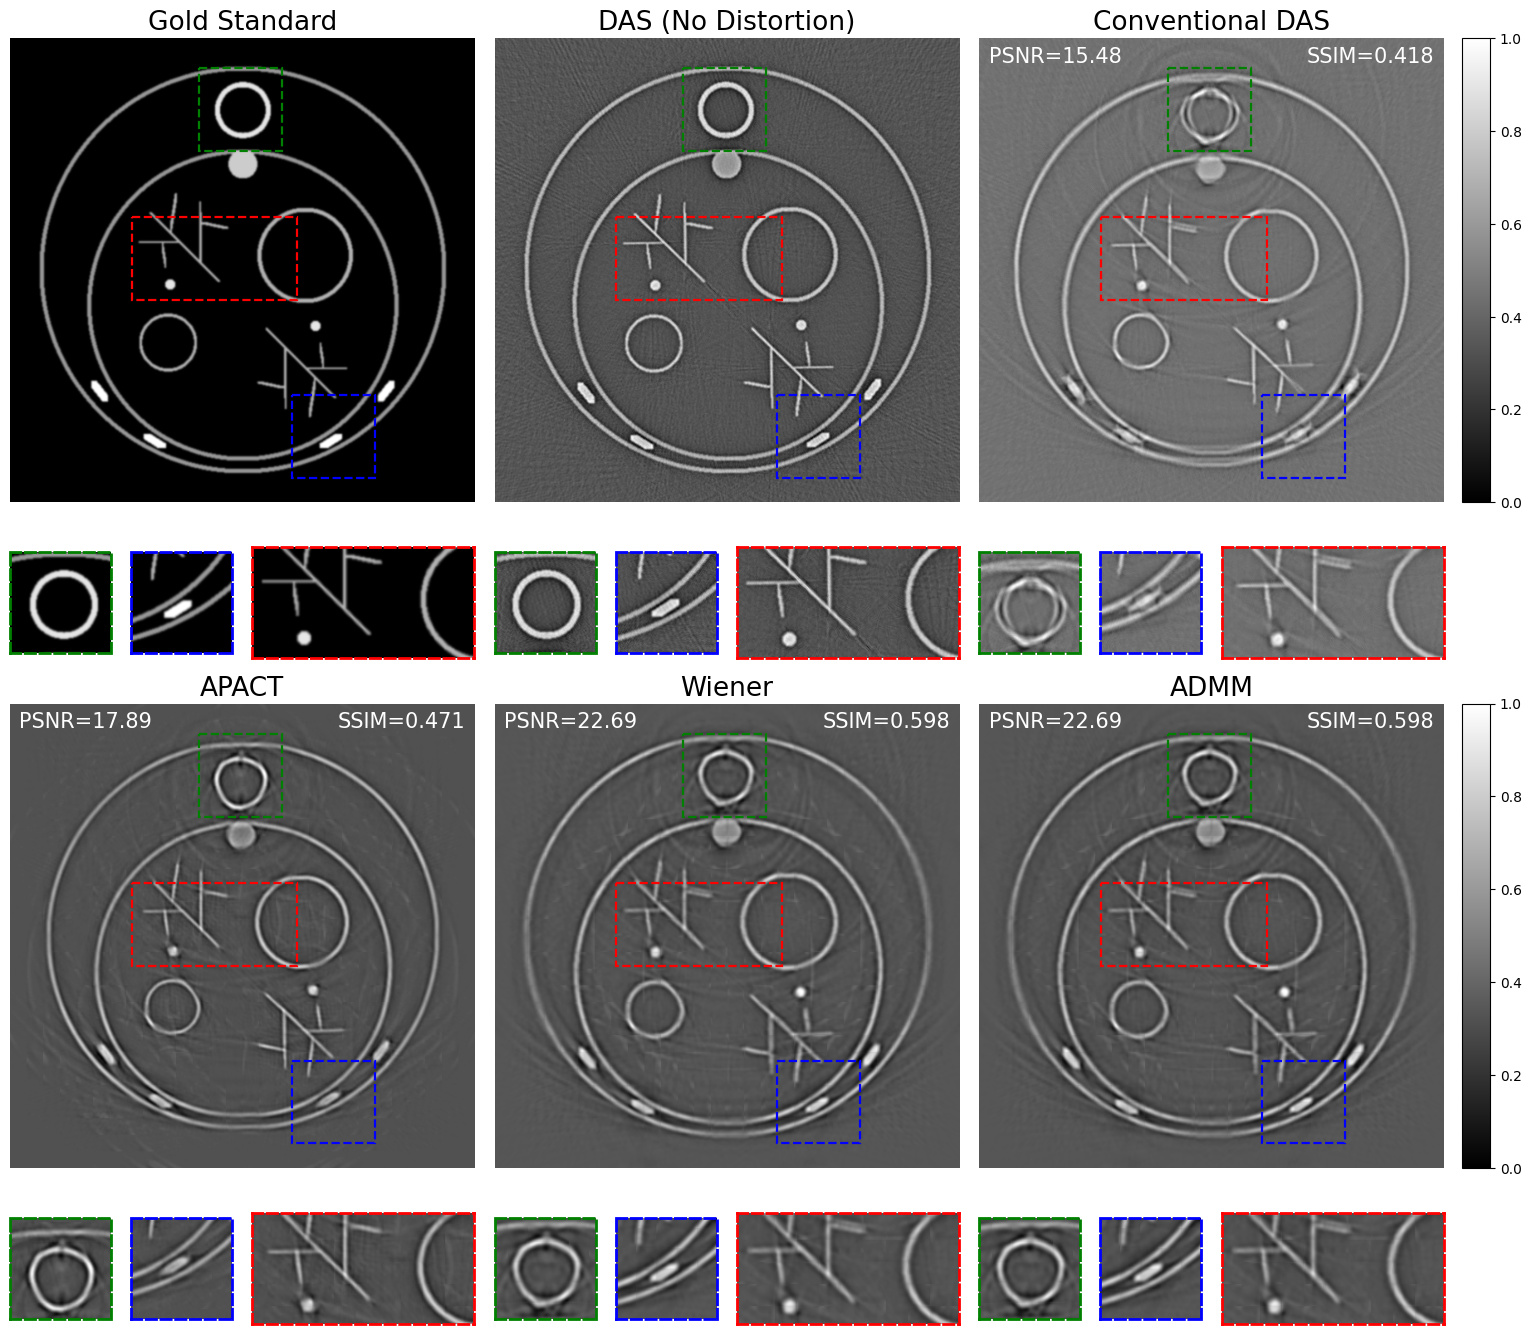

In [27]:
patches = [(36, 227, 100, 100, 'green'), (430, 340, 100, 100,'blue'), (216, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
norm = matplotlib.colors.Normalize(vmax=1, vmin=-0)
for idx, (rec_full, method) in enumerate(zip([IP_img, gt, baseline, rec_full_apact, rec_full_wiener, rec_full_admm], ['Gold Standard', 'DAS (No Distortion)', 'Conventional DAS', 'APACT', 'Wiener', 'ADMM'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 1:
        plt.title('PSNR={:.2f}'.format(psnr(gt, rec_full, data_range=1)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(gt, rec_full, data_range=1)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        # if idx > 1:
        #     plt.title('PSNR={:.2f}'.format(psnr(gt[x:x+h, y:y+w], rec_full[x:x+h, y:y+w], data_range=1)), loc='left', fontsize=12)
        #     plt.title('SSIM={:.3f}'.format(ssim(gt[x:x+h, y:y+w], rec_full[x:x+h, y:y+w], data_range=1)), loc='right',y=-0.1, fontsize=12)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

Compare different attention weights.

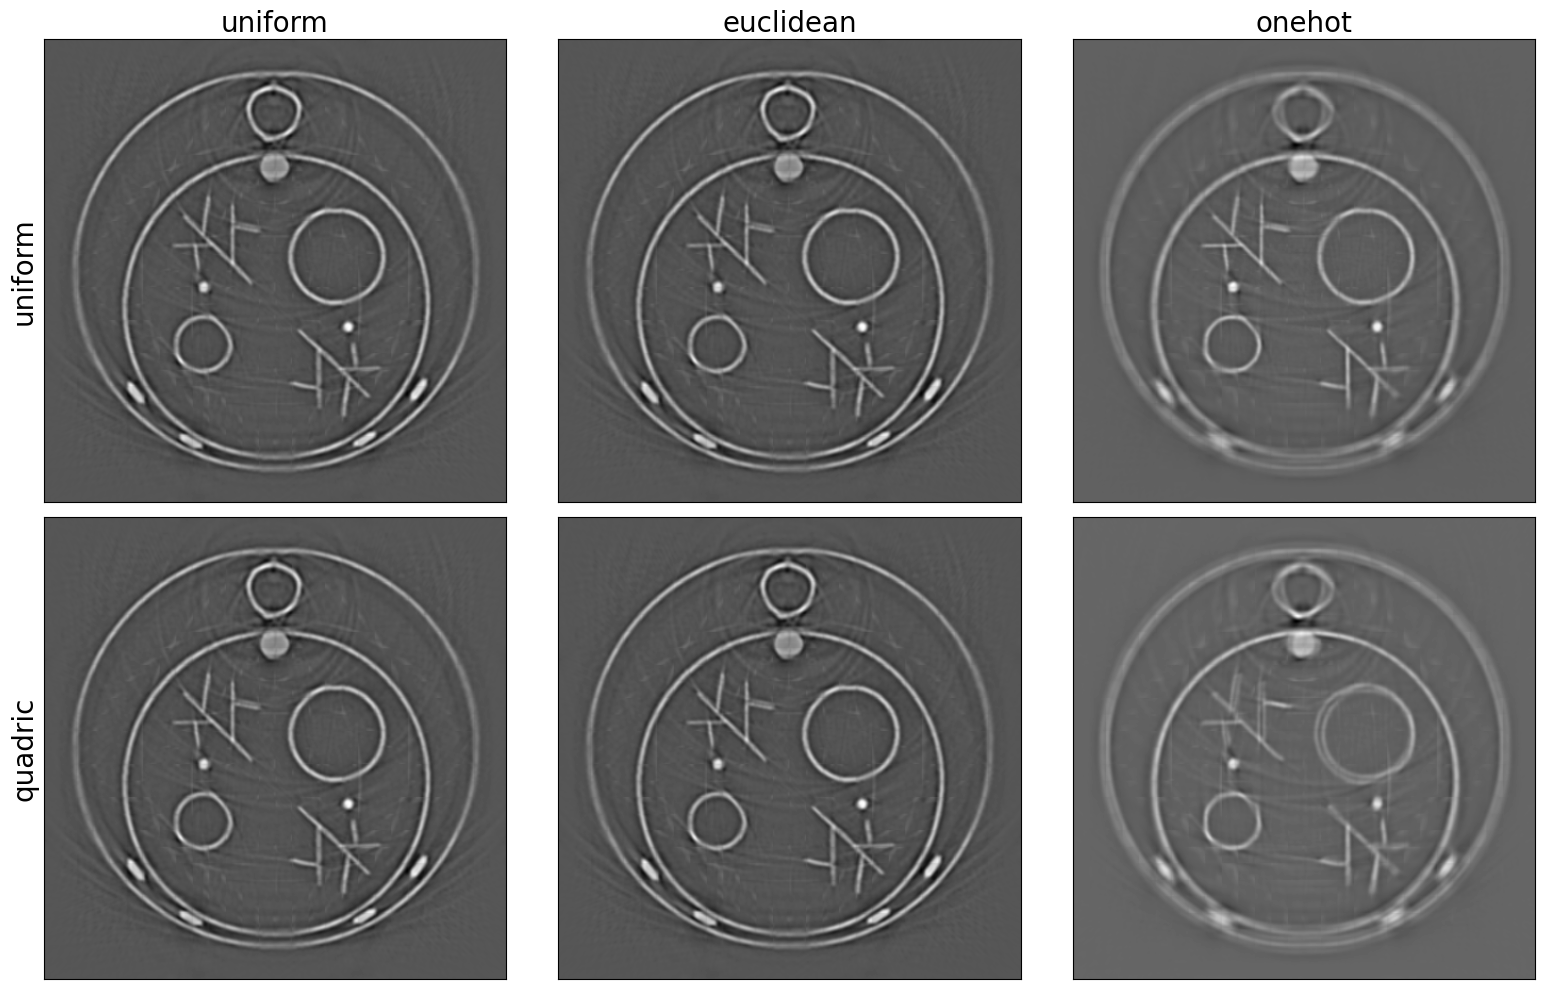

In [28]:
fig = plt.figure(figsize=(16, 10))
for i, attention in enumerate(['uniform', 'euclidean', 'onehot']):
    for j, mode in enumerate(['uniform', 'quadric']):
        ax = plt.subplot(2,3,j*3+i+1)
        delays = get_delays(R, v0, v1, n_delays, mode)
        rec_full = deconv_full_img(wiener, recons, gaussian_window, delays, attention)
        rec_full = normalize(rec_full)
        plt.imshow(rec_full, cmap='gray', norm=norm)
        if j == 0:
            plt.title(attention, fontsize=20)
        if i == 0:
            plt.ylabel(mode, fontsize=20)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()